## Feature Selection - Lasso Regularization

- **Author:** Ashutosh Shirsat  
- **Project:** Data Science/ML 
- **Objective:** feature selection - Lasso Regularization.  

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, validation_curve, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('data/cleanThyroidData.csv')

# 2. Outcome variable and feature separation
target_col = 'thyroid'
X = df.drop(columns=target_col)
y = df[target_col].astype(int)  # ensure binary 0/1

# 3. Identify categorical and numeric features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number, 'bool']).columns.tolist()

# 4. Train/Test Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123456, stratify=y
)

X.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U_measured,T4U,FTI,referral_source
0,36,Female,False,False,False,False,False,False,False,True,...,False,False,False,2.079442,2.186051,90.0,True,2.022871,85.0,other
1,40,Female,False,False,False,False,False,False,False,False,...,False,False,False,2.041220,2.174752,104.0,True,2.025513,96.0,other
2,40,Female,False,False,False,False,False,False,False,False,...,False,False,False,2.517696,2.151762,88.0,True,1.993339,105.0,other
3,77,Female,False,False,False,False,False,False,False,False,...,False,False,False,1.879465,2.186051,107.0,True,2.032088,95.0,other
4,51,Female,False,False,False,False,False,False,False,False,...,False,False,False,1.879465,2.151762,93.0,True,1.997418,106.0,SVI


In [2]:
# 5. Preprocessing Pipelines
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 6. Model Pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=123456))
])

# 7. Hyperparameter grid and cross-validation
param_grid = {
    'clf__C': np.logspace(-3, 2, 20)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123456)
grid = GridSearchCV(
    pipe, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, return_train_score=True
)
grid.fit(X_train, y_train)

# 8. Results: Best Parameter
print("Best C:", grid.best_params_['clf__C'])
print("Best CV ROC-AUC:", grid.best_score_)



Best C: 0.06951927961775606
Best CV ROC-AUC: 0.9660902963549685


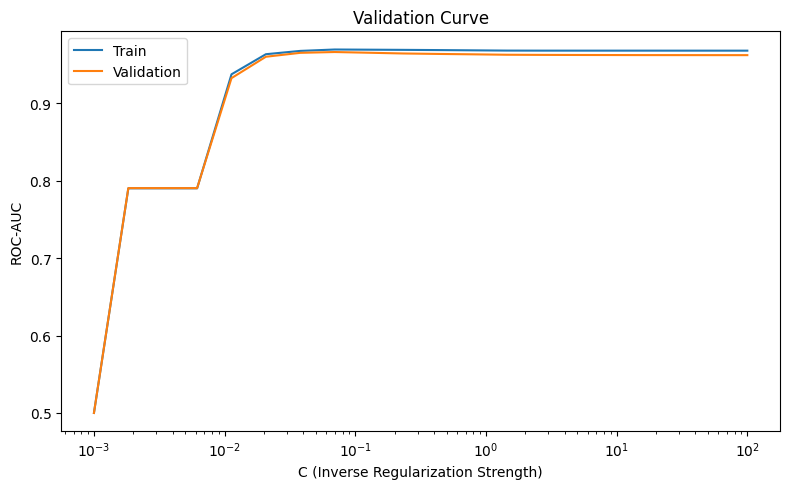

In [3]:
# 9. Validation Curve (Train vs Test)
train_scores, test_scores = validation_curve(
    grid.best_estimator_, X_train, y_train,
    param_name='clf__C',
    param_range=param_grid['clf__C'],
    cv=cv, scoring='roc_auc', n_jobs=-1
)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
plt.figure(figsize=(8, 5))
plt.semilogx(param_grid['clf__C'], train_mean, label='Train')
plt.semilogx(param_grid['clf__C'], test_mean, label='Validation')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('ROC-AUC')
plt.title('Validation Curve')
plt.legend()
plt.tight_layout()
plt.show()

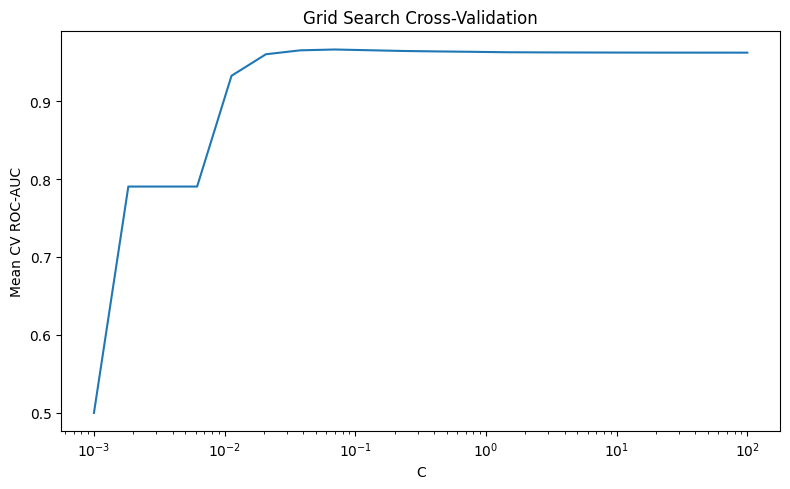

In [4]:
# 10. Cross-validation score plot
import pandas as pd
results = pd.DataFrame(grid.cv_results_)
plt.figure(figsize=(8, 5))
plt.semilogx(results['param_clf__C'].astype(float), results['mean_test_score'], label='CV ROC-AUC')
plt.xlabel('C')
plt.ylabel('Mean CV ROC-AUC')
plt.title('Grid Search Cross-Validation')
plt.tight_layout()
plt.show()

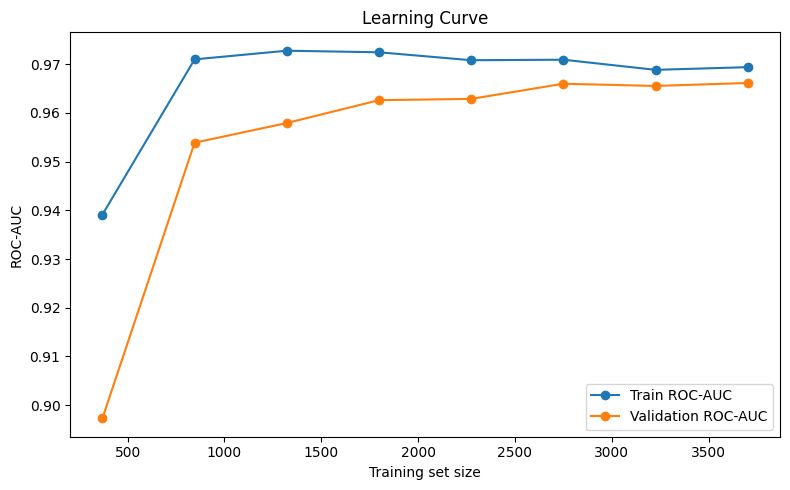

In [5]:
# 11. Learning Curve
train_sizes, train_scores_lc, test_scores_lc = learning_curve(
    grid.best_estimator_, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 8), cv=cv, scoring='roc_auc', n_jobs=-1
)
train_mean_lc = train_scores_lc.mean(axis=1)
test_mean_lc = test_scores_lc.mean(axis=1)
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean_lc, 'o-', label='Train ROC-AUC')
plt.plot(train_sizes, test_mean_lc, 'o-', label='Validation ROC-AUC')
plt.xlabel('Training set size')
plt.ylabel('ROC-AUC')
plt.title('Learning Curve')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# 12. Feature Selection: LASSO zero coefficients = dropped
ohe = grid.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(categorical_features) if categorical_features else []
all_feature_names = numeric_features + list(cat_names)

coefs = grid.best_estimator_.named_steps['clf'].coef_[0]
feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'coef': coefs,
    'abs_coef': np.abs(coefs),
}).sort_values('coef', ascending=False)

feature_importance['rel_varimp'] = (100 * feature_importance['abs_coef'] / feature_importance['abs_coef'].max()).round(2)
feature_importance = feature_importance.sort_values('rel_varimp', ascending=False)

selected_features = feature_importance[feature_importance['coef'] != 0]
not_selected_features = feature_importance[feature_importance['coef'] == 0]

print("\nTotal Selected Features:", len(selected_features))
print("Total Not Selected Features:", len(not_selected_features))

print("\nFeatures (with VARIMP):")
print(feature_importance[['feature', 'coef', 'abs_coef', 'rel_varimp']].to_string(index=False))



Total Selected Features: 13
Total Not Selected Features: 15

Features (with VARIMP):
              feature      coef  abs_coef  rel_varimp
                  TSH  2.156332  2.156332      100.00
         on_thyroxine -1.023352  1.023352       47.46
                   T3  0.743274  0.743274       34.47
      thyroid_surgery -0.521671  0.521671       24.19
                  FTI  0.375467  0.375467       17.41
   query_hyperthyroid  0.260514  0.260514       12.08
                  T4U -0.197118  0.197118        9.14
referral_source_other  0.187412  0.187412        8.69
                tumor  0.119215  0.119215        5.53
                psych -0.074357  0.074357        3.45
                  age  0.059956  0.059956        2.78
             pregnant -0.058834  0.058834        2.73
       I131_treatment -0.015526  0.015526        0.72
   query_on_thyroxine  0.000000  0.000000        0.00
                 sick  0.000000  0.000000        0.00
               goitre  0.000000  0.000000        0


Test ROC-AUC: 0.9788


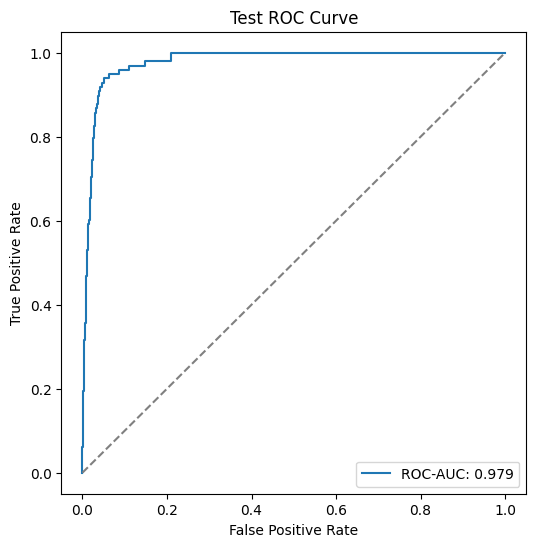

In [7]:
# 13. Final Model Evaluation: ROC-AUC on Test
y_pred_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nTest ROC-AUC: {roc_auc:.4f}")

# 14. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC: {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], ls='--', c='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

In [8]:
# 14. Drop features which has LASSO zero coefficients = dropped from from original dataframe 'df.
# Map one-hot encoded feature names back to original columns for df selection
# Only keep original columns that contributed to selected features

# Extract original columns from selected one-hot encoded features
selected_feature_names = selected_features['feature'].tolist()
original_cols_to_keep = set()

for feat in selected_feature_names:
    # Check if feature is a one-hot encoded categorical
    matched = False
    for cat in categorical_features:
        if feat.startswith(cat + "_"):
            original_cols_to_keep.add(cat)
            matched = True
            break
    if not matched and feat in df.columns:
        original_cols_to_keep.add(feat)

# Always keep the target column if present
if target_col in df.columns:
    original_cols_to_keep.add(target_col)

df_featureselected = df[list(original_cols_to_keep)]
df_featureselected.head()

# Save the feature-selected DataFrame to a new CSV file
df_featureselected.to_csv('data/thyroidData_Lasso_featureselected.csv', index=False)